In [228]:
import numpy as np
import matplotlib.pyplot as plt


In [229]:
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry

province_capitals_coordinates = {
    "Mazowieckie": (52.2297, 21.0122), 
    "Podlaskie": (53.1325, 23.1688), 
    "Pomorskie": (54.3520, 18.6466),  
    "Śląskie": (50.2649, 19.0238), 
    "Świętokrzyskie": (50.8661, 20.6286), 
    "Małopolskie": (50.0647, 19.9450), 
    "Lubelskie": (51.2465, 22.5684),  
    "Łódzkie": (51.7592, 19.4560), 
    "Warmińsko-mazurskie": (53.7784, 20.4801),  
    "Opolskie": (50.6721, 17.9213),
    "Wielkopolskie": (52.4064, 16.9252), 
    "Podkarpackie": (50.0412, 21.9991), 
    "Zachodniopomorskie": (53.4285, 14.5528),  
    "Kujawsko-pomorskie": (53.0138, 18.5984),  
    "Dolnośląskie": (51.1079, 17.0385),  
    "Lubuskie": (51.9356, 15.5064) 
}

def get_coordinates(city_name):
    """Funkcja zwraca współrzędne geograficzne dla podanego miasta."""
    return province_capitals_coordinates.get(city_name, "Nie znaleziono takiego miasta")

cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

mean_pm10_provinces = np.zeros(province_capitals_coordinates.__len__())
days_above_50_pm10 = np.zeros(province_capitals_coordinates.__len__())
province_disease_rate_df = pd.DataFrame()

province_disease_rate_df['province'] = []
province_disease_rate_df['rate'] = []
iterator = 0
for city, coordinates in province_capitals_coordinates.items():
    url = "https://air-quality-api.open-meteo.com/v1/air-quality"
    params = {
        "latitude": coordinates[0],
        "longitude": coordinates[1],
        "hourly": ["pm10"],
        "start_date": "2023-01-01",
	    "end_date": "2023-12-31"
    }
    responses = openmeteo.weather_api(url, params=params)
    response = responses[0]
    hourly = response.Hourly()

    hourly_pm10 = hourly.Variables(0).ValuesAsNumpy()

    hourly_data = {"date": pd.date_range(
        start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
        end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
        freq=pd.Timedelta(seconds=hourly.Interval()),
        inclusive="left"
    )}
    hourly_data["pm10"] = hourly_pm10
    
    hourly_dataframe = pd.DataFrame(data=hourly_data)
    # czyszczenie danych z wierszami zawierającymi conajmniej jedną pustą kolumnę
    hourly_dataframe.dropna()
    grouped_by_days = hourly_dataframe.copy()
    grouped_by_days['date'] = grouped_by_days['date'].astype(str).str[:10]
    grouped_by_days = grouped_by_days.groupby(by="date").agg('mean') 



    mean_pm10 = hourly_dataframe["pm10"].mean()

    mean_pm10_provinces[iterator] = mean_pm10
    days_above_50_pm10[iterator] = grouped_by_days[grouped_by_days['pm10']>50].count()
    province_disease_rate_df = province_disease_rate_df._append({'province': city.lower(), 'rate': mean_pm10}, ignore_index=True)
    iterator+=1
    
# dane pochodzą z dziedzinowych baz danych gusu, niestety ale usługa, która pozwala pobierać dane w formacie xlsx,cv,json nie działa poprawnie i dane musiały zostać wpisane recznię
province_capitals_disease_rate = {
    "mazowieckie": 11.3,  
    "podlaskie": 5.8, 
    "pomorskie": 9.7,  
    "śląskie": 15.8, 
    "świętokrzyskie": 12.1,  
    "małopolskie": 9.7,  
    "lubelskie": 14.0,  
    "łódzkie": 13.0, 
    "warmińsko-mazurskie": 5.9, 
    "opolskie": 9.5, 
    "wielkopolskie": 6.3, 
    "podkarpackie": 9.4,  
    "zachodniopomorskie": 10.6,  
    "kujawsko-pomorskie": 10.9, 
    "dolnośląskie": 13.8, 
    "lubuskie": 9.5 
}

disease_rate_provinces = np.zeros(province_capitals_coordinates.__len__())
iterator = 0

for city, rate in province_capitals_disease_rate.items():
    disease_rate_provinces[iterator] = rate
    iterator+=1


   


C:\Users\Damian\AppData\Local\Temp\ipykernel_9580\3807113427.py:75: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  days_above_50_pm10[iterator] = grouped_by_days[grouped_by_days['pm10']>50].count()
C:\Users\Damian\AppData\Local\Temp\ipykernel_9580\3807113427.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  province_disease_rate_df = province_disease_rate_df._append({'province': city.lower(), 'rate': mean_pm10}, ignore_index=True)
C:\Users\Damian\AppData\Local\Temp\ipykernel_9580\3807113427.py:75: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  d

0.567040689760659


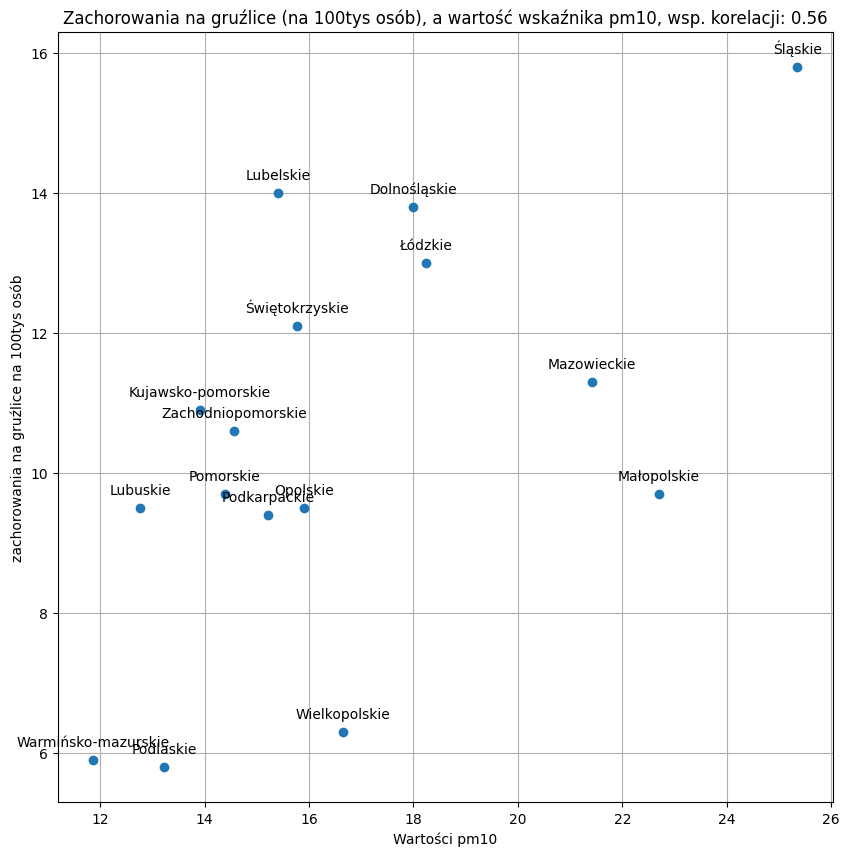

In [230]:
x_std = (mean_pm10_provinces-np.mean(mean_pm10_provinces))/np.std(mean_pm10_provinces)  
y_std = (disease_rate_provinces-np.mean(disease_rate_provinces))/np.std(disease_rate_provinces) 
np.mean(x_std*y_std)
print(np.mean(x_std*y_std))
plt.figure(figsize=(10, 10))
plt.plot(mean_pm10_provinces, disease_rate_provinces, marker='o',linestyle='None' )
i =0
for province, coordinates in province_capitals_coordinates.items():
    plt.annotate(province, (mean_pm10_provinces[i], disease_rate_provinces[i]), textcoords="offset points", xytext=(0,10), ha='center')
    i+=1


plt.title('Zachorowania na gruźlice (na 100tys osób), a wartość wskaźnika pm10, wsp. korelacji: 0.56')
plt.xlabel('Wartości pm10')
plt.ylabel('zachorowania na gruźlice na 100tys osób')
plt.grid(True)
plt.savefig("pm10.png", dpi=300)
plt.show()

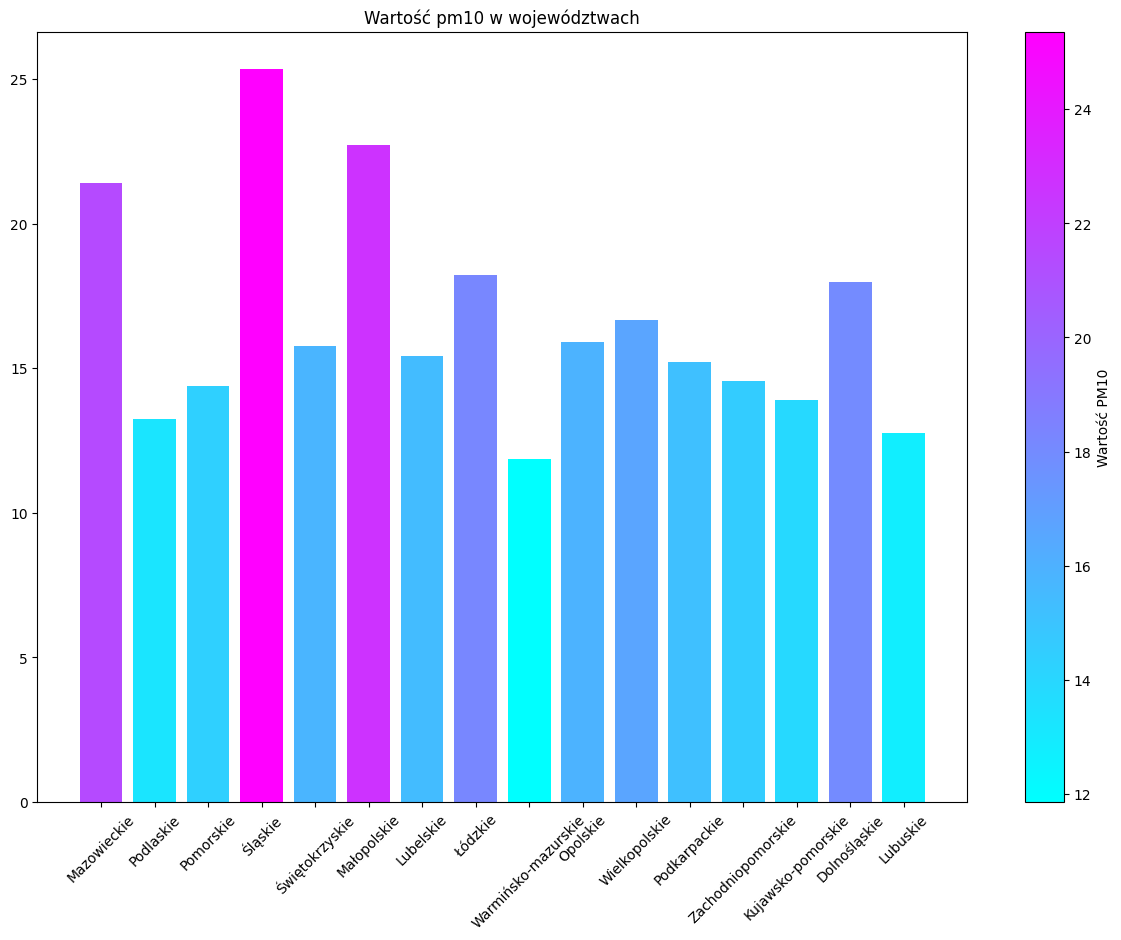

In [231]:
import matplotlib.colors as mcolors

provinces_capital_names = []
for city, coordinates in province_capitals_coordinates.items():
    provinces_capital_names.append(city)

norm = mcolors.Normalize(vmin=min(mean_pm10_provinces), vmax=max(mean_pm10_provinces))
colors = plt.cm.cool(norm(mean_pm10_provinces))

location = np.arange(len(province_capitals_coordinates))
plt.figure(figsize=(15, 10))
plt.title("Wartość pm10 w województwach")
bars = plt.bar(location, mean_pm10_provinces, color=colors)
plt.xticks(location, provinces_capital_names, rotation=45)

# Dodaj legendę
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='cool'), ax=plt.gca(), orientation='vertical', label='Wartość PM10')

plt.savefig("wojewodztwa_bar_pm10.png", dpi=300)
plt.show()

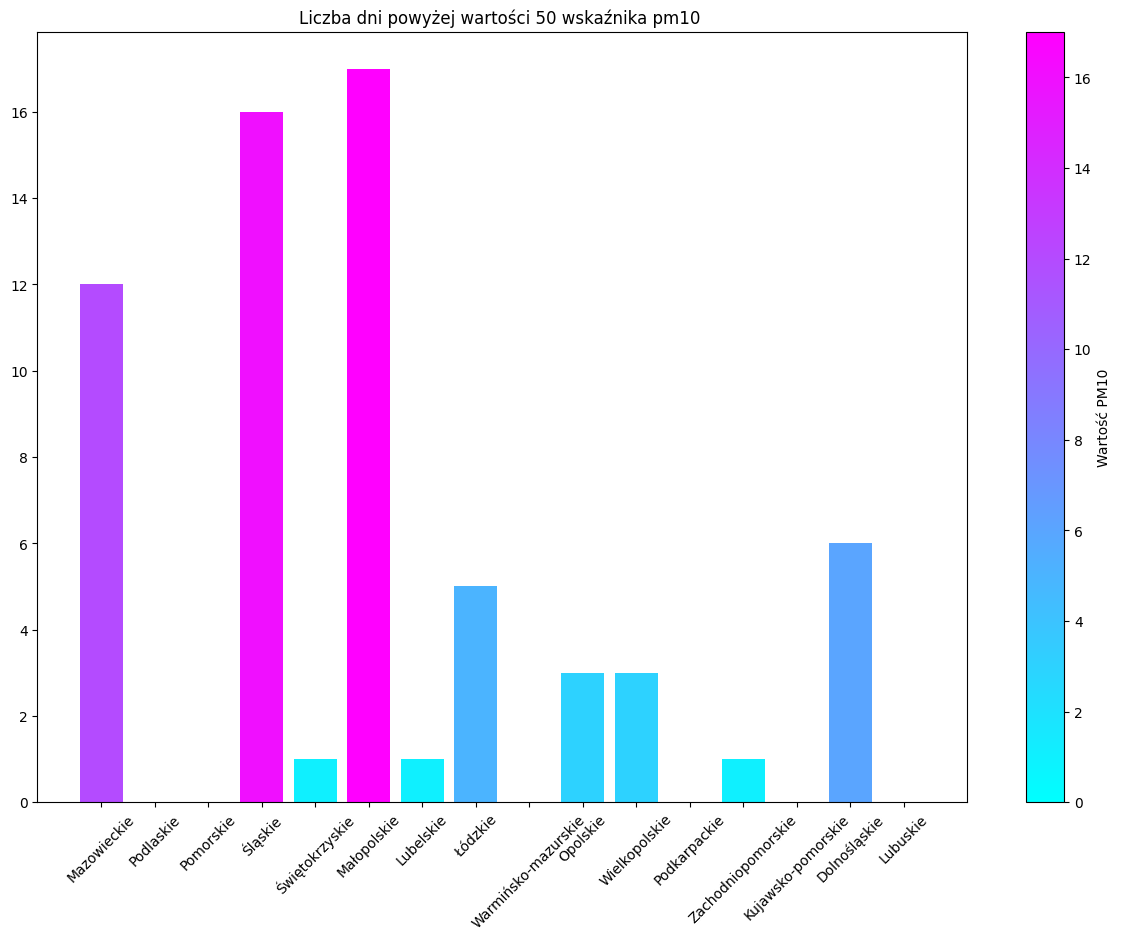

In [232]:

norm = mcolors.Normalize(vmin=min(days_above_50_pm10), vmax=max(days_above_50_pm10))
colors = plt.cm.cool(norm(days_above_50_pm10))

location = np.arange(len(province_capitals_coordinates))
plt.figure(figsize=(15, 10))
plt.title("Liczba dni powyżej średniodobowej wartości 50 wskaźnika pm10 ")
bars = plt.bar(location, days_above_50_pm10, color=colors)
plt.xticks(location, provinces_capital_names, rotation=45)

# Dodaj legendę
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='cool'), ax=plt.gca(), orientation='vertical', label='Wartość PM10')

plt.savefig("up50_bar_pm10.png", dpi=300)
plt.show()

0.5845999522906509


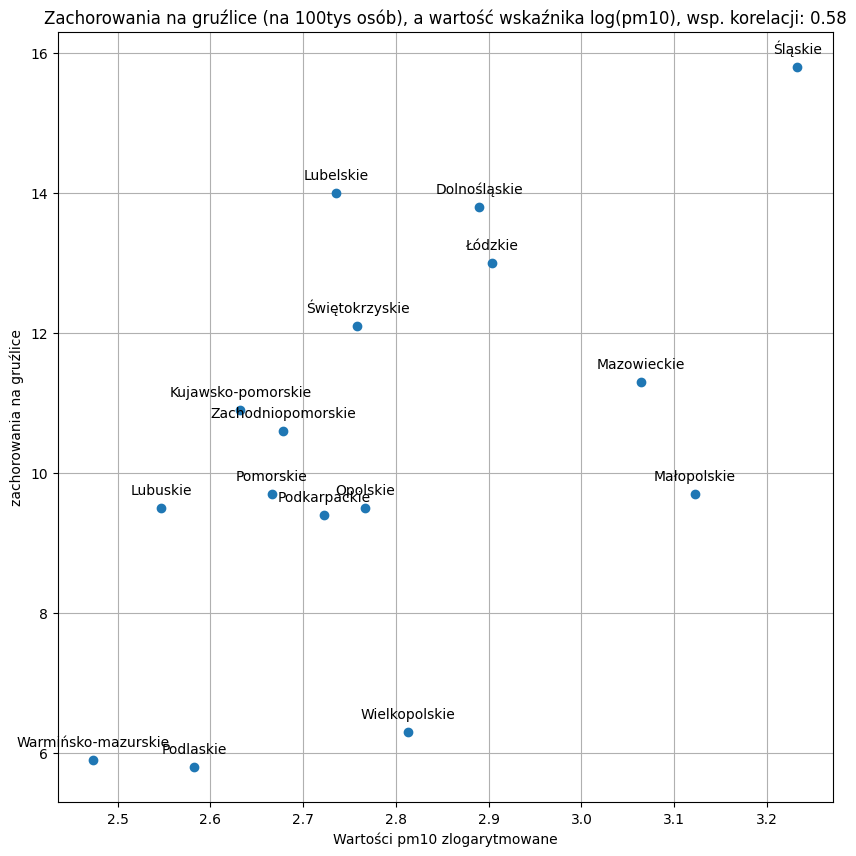

In [233]:

log_mean_pm10_provinces=np.log(mean_pm10_provinces)
x_std = (log_mean_pm10_provinces-np.mean(log_mean_pm10_provinces))/np.std(log_mean_pm10_provinces)  
y_std = (disease_rate_provinces-np.mean(disease_rate_provinces))/np.std(disease_rate_provinces) 
np.mean(x_std*y_std)
print(np.mean(x_std*y_std))

plt.figure(figsize=(10, 10))
plt.plot(log_mean_pm10_provinces, disease_rate_provinces, marker='o',linestyle='None' )
i = 0
for province, coordinates in province_capitals_coordinates.items():
    plt.annotate(province, (log_mean_pm10_provinces[i], disease_rate_provinces[i]), textcoords="offset points", xytext=(0,10), ha='center')
    i+=1

plt.title('Zachorowania na gruźlice (na 100tys osób), a wartość wskaźnika log(pm10), wsp. korelacji: 0.58')
plt.xlabel('Wartości pm10 zlogarytmowane')
plt.ylabel('zachorowania na gruźlice')
plt.grid(True)

plt.savefig("log(pm10).png", dpi=300)
plt.show()

0.5789410307461844


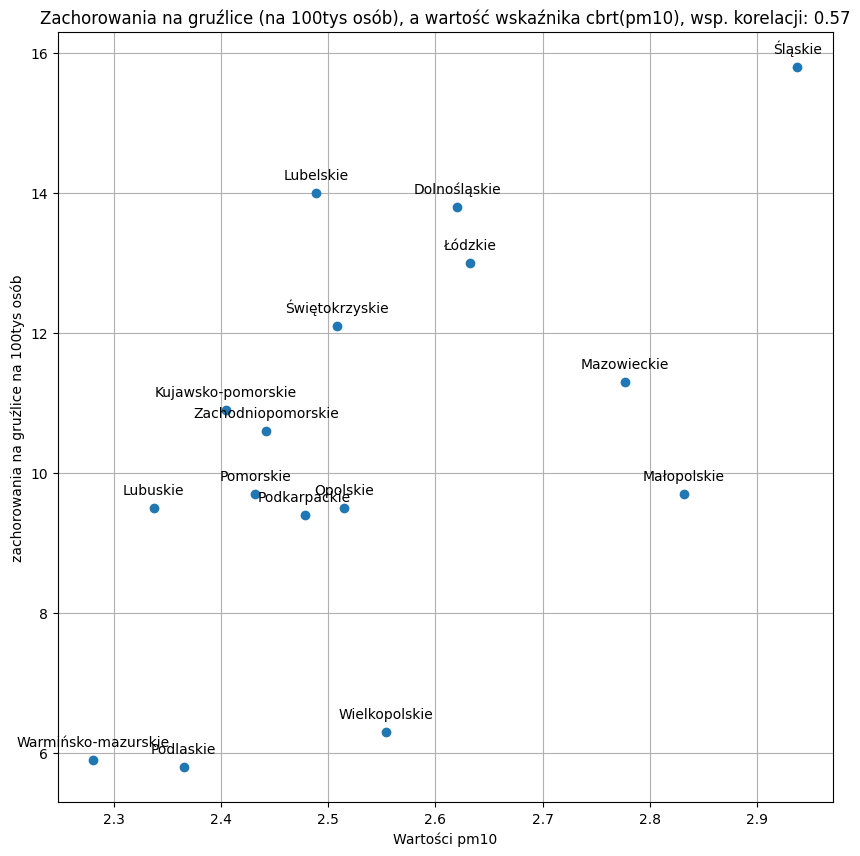

In [234]:
cbrt_mean_pm10_provinces=np.cbrt(mean_pm10_provinces)

x_std = (cbrt_mean_pm10_provinces-np.mean(cbrt_mean_pm10_provinces))/np.std(cbrt_mean_pm10_provinces)  
y_std = (disease_rate_provinces-np.mean(disease_rate_provinces))/np.std(disease_rate_provinces) 
np.mean(x_std*y_std)
print(np.mean(x_std*y_std))
plt.figure(figsize=(10, 10))
plt.plot(cbrt_mean_pm10_provinces, disease_rate_provinces, marker='o',linestyle='None' )
i =0
for province, coordinates in province_capitals_coordinates.items():
    plt.annotate(province, (cbrt_mean_pm10_provinces[i], disease_rate_provinces[i]), textcoords="offset points", xytext=(0,10), ha='center')
    i+=1


plt.title('Zachorowania na gruźlice (na 100tys osób), a wartość wskaźnika cbrt(pm10), wsp. korelacji: 0.57')
plt.xlabel('Wartości pm10')
plt.ylabel('zachorowania na gruźlice na 100tys osób')
plt.grid(True)
plt.savefig("sqrt(pm10).png", dpi=300)
plt.show()

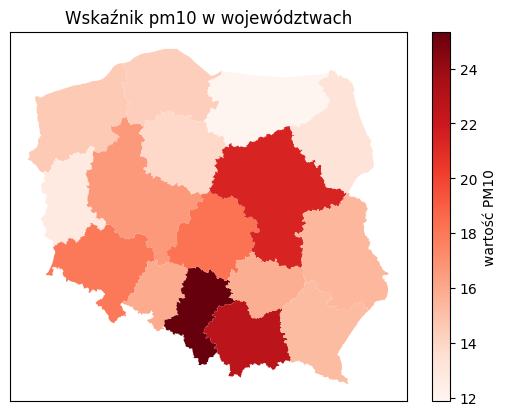

In [235]:
import geopandas as gpd
import matplotlib.pyplot as plt

# https://gis-support.pl/baza-wiedzy-2/dane-do-pobrania/granice-administracyjne/
map_dataframe = gpd.read_file("wojewodztwa.shx")


merged_dataframe = map_dataframe.merge(province_disease_rate_df, left_on=["JPT_NAZWA_"], right_on=["province"])

merged_dataframe.plot( column = "rate",cmap="Reds", legend=True,
                      legend_kwds={'label': "wartość PM10",
                                   'orientation': "vertical"})

plt.gca().axes.xaxis.set_visible(False)
plt.gca().axes.yaxis.set_visible(False)
plt.title("Wskaźnik pm10 w województwach")
plt.savefig("wojewodztwa_pm10.png", dpi=300)
plt.show()